# Data Preparation

<img src="https://octodex.github.com/images/privateinvestocat.jpg" alt="Kit" title="Cat" width="350" height="200" />
*(image from octodex github)*


In [49]:
#Dataframe packages
import zipfile
import json
import objectpath
import pandas as pd
import numpy as np
import os
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np
from collections import Counter

# Text Mining
import nltk
nltk.download("stopwords")

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA

import ipywidgets as wg

#Oversampling
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
name= wg.Text(value='test')
display(name)

Text(value='test')

## Data Extraction

### Sentiment Data

In [51]:
# Define Empty lists
d = None  
data = None  
score=[]
magnitude=[]
petid=[]

string = name.value + "_sentiment.zip"
# Read Zip File and Export a Dataset with the Score and the ID
filepath= os.path.join(r"C:\Users\alexandra\Documents\Kaggle", string)

with zipfile.ZipFile(filepath, "r") as z:
   for filename in z.namelist():  
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))
         json_tree = objectpath.Tree(d['documentSentiment'])
         result_tuple = tuple(json_tree.execute('$..score'))
         result_tuple2=tuple(json_tree.execute('$..magnitude'))
         score.append(result_tuple)
         magnitude.append(result_tuple2)
         
      petid.append(filename.replace('.json',''))

# Output with sentiment data for each pet
# Output with sentiment data for each pet
sentimental_analysis = pd.concat([ pd.DataFrame(petid, columns =['PetID']) ,pd.DataFrame(score, columns =['sentiment_document_score']),
                                                pd.DataFrame(magnitude, columns =['sentiment_document_magnitude'])],axis =1)

### Metadata

In [52]:
# Define Empty lists
d = None  
data = None  
description=[]
topicality=[]
imageid=[]

string=name.value + "_metadata.zip"
filepath= os.path.join(r"C:\Users\alexandra\Documents\Kaggle", string)
# Read Zip File and Export a Dataset with the Topicality and Description for each Image
with zipfile.ZipFile(filepath, "r") as z:
   for filename in z.namelist():  
       #Open the Zip File
      with z.open(filename) as f:  
          #Read the json File
          data = f.read()
          d = json.loads(data.decode("utf-8"))
          #Check if the file contains the parent label Annotations and export description and topicality
          if 'labelAnnotations' in d:
             json_tree = objectpath.Tree(d['labelAnnotations'])
             image_metadata1 = list(tuple(json_tree.execute('$..description')))
             image_metadata2 =  list(tuple(json_tree.execute('$..topicality')))

             #Create a list of all descriptions and topicality
             description.append(image_metadata1)
             topicality.append(image_metadata2)
         
             #Create a list with all image id name
             imageid.append(filename.replace('.json',''))


# Prepare the output by renaming all variables
description=pd.DataFrame(description)
topicality=pd.DataFrame(topicality)

new_names = [(i,'metadata_description_'+str(i)) for i in description.iloc[:, 0:].columns.values]
description.rename(columns = dict(new_names), inplace=True)

new_names = [(i,'metadata_topicality_'+str(i)) for i in topicality.iloc[:, 0:].columns.values]
topicality.rename(columns = dict(new_names), inplace=True)

# Output with sentiment data for each pet
image_metadata = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,topicality,description],axis =1)

# create the PetId variable
image_metadata['PetID'] = image_metadata['ImageId'].str.split('-').str[0]


##############
# TOPICALITY #
##############

image_metadata['metadata_topicality_mean'] = image_metadata.iloc[:,1:10].mean(axis=1)
image_metadata['metadata_topicality_mean']  = image_metadata.groupby(['PetID'])['metadata_topicality_mean'].transform('mean') 

image_metadata['metadata_topicality_max'] = image_metadata.iloc[:,1:10].max(axis=1)
image_metadata['metadata_topicality_max'] = image_metadata.groupby(['PetID'])['metadata_topicality_max'].transform(max)

image_metadata['metadata_topicality_min'] = image_metadata.iloc[:,1:10].min(axis=1)
image_metadata['metadata_topicality_min'] = image_metadata.groupby(['PetID'])['metadata_topicality_min'].transform(min)


image_metadata['metadata_topicality_0_mean']  = image_metadata.groupby(['PetID'])['metadata_topicality_0'].transform('mean')
image_metadata['metadata_topicality_0_max'] = image_metadata.groupby(['PetID'])['metadata_topicality_0'].transform(max)
image_metadata['metadata_topicality_0_min'] = image_metadata.groupby(['PetID'])['metadata_topicality_0'].transform(min)


###############
# DESCRIPTION #
###############

# Create Features from the Images
image_metadata['L_metadata_0_cat']=image_metadata['metadata_description_0'].str.contains("cat").astype(int)
image_metadata['L_metadata_0_dog'] =image_metadata['metadata_description_0'].str.contains("dog").astype(int)

image_metadata['L_metadata_any_cat']=image_metadata.apply(lambda row: row.astype(str).str.contains('cat').any(), axis=1)
image_metadata['L_metadata_any_dog']=image_metadata.apply(lambda row: row.astype(str).str.contains('dog').any(), axis=1)

image_metadata['L_metadata_0_cat_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_0_cat'].transform('sum')
image_metadata['L_metadata_0_dog_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_0_dog'].transform('sum')

image_metadata['L_metadata_any_cat_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_any_cat'].transform('sum')
image_metadata['L_metadata_any_dog_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_any_dog'].transform('sum')

image_metadata = image_metadata[['PetID','metadata_topicality_max','metadata_topicality_mean','metadata_topicality_min','metadata_topicality_0_mean','metadata_topicality_0_max','metadata_topicality_0_min','L_metadata_0_cat_sum','L_metadata_0_dog_sum','L_metadata_any_cat_sum','L_metadata_any_dog_sum']]
image_metadata=image_metadata.drop_duplicates('PetID')


### Metadata Colors

In [53]:
d = None  
data = None  

color_score_mean=[]
color_score_min=[]
color_score_max=[]

color_pixelfrac_mean=[]
color_pixelfrac_min=[]
color_pixelfrac_max=[]

crops=[]

imageid=[]

# Read Zip File and Export a Dataset with the Score and the ID
with zipfile.ZipFile(filepath, "r") as z:
   for filename in z.namelist():  
      with z.open(filename) as f:  
          data = f.read()
          d = json.loads(data.decode("utf-8"))
          file_keys = list(d.keys())
          if  'imagePropertiesAnnotation' in file_keys:
              file_colors = d['imagePropertiesAnnotation']['dominantColors']['colors']
                        
              file_color_score_mean = np.asarray([x['score'] for x in file_colors]).mean()
              file_color_pixelfrac_mean = np.asarray([x['pixelFraction'] for x in file_colors]).mean()
              
              file_color_score_min = np.asarray([x['score'] for x in file_colors]).min()
              file_color_pixelfrac_min = np.asarray([x['pixelFraction'] for x in file_colors]).min()

              
              file_color_score_max = np.asarray([x['score'] for x in file_colors]).max()
              file_color_pixelfrac_max = np.asarray([x['pixelFraction'] for x in file_colors]).max()
              
              
          #Create a list with all image id name
          imageid.append(filename.replace('.json',''))
          
          color_score_mean.append(file_color_score_mean)
          color_score_min.append(file_color_score_min)
          color_score_max.append(file_color_score_max)
          
          
          color_pixelfrac_mean.append(file_color_pixelfrac_mean)
          color_pixelfrac_min.append(file_color_pixelfrac_min)
          color_pixelfrac_max.append(file_color_pixelfrac_max)

        
image_properties = pd.concat([pd.DataFrame({'ImageId':imageid}),pd.DataFrame({'metadata_color_pixelfrac_mean':color_pixelfrac_mean}), pd.DataFrame({'metadata_color_pixelfrac_min':color_pixelfrac_min}),pd.DataFrame({'metadata_color_pixelfrac_max':color_pixelfrac_max}),pd.DataFrame({'metadata_color_score_mean':color_score_mean}),pd.DataFrame({'metadata_color_score_min':color_score_min}),pd.DataFrame({'metadata_color_score_max':color_score_max})],axis=1)

# create the PetId variable
image_properties['PetID'] = image_properties['ImageId'].str.split('-').str[0]


##############
# COLOR INFO #
##############
image_properties['metadata_color_pixelfrac_mean']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_mean'].transform('mean') 
image_properties['metadata_color_pixelfrac_min']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_min'].transform(min) 
image_properties['metadata_color_pixelfrac_max']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_max'].transform(max) 

image_properties['metadata_color_score_mean']  = image_properties.groupby(['PetID'])['metadata_color_score_mean'].transform('mean') 
image_properties['metadata_color_score_min']  = image_properties.groupby(['PetID'])['metadata_color_score_min'].transform(min) 
image_properties['metadata_color_score_max']  = image_properties.groupby(['PetID'])['metadata_color_score_max'].transform(max) 

image_properties=image_properties.drop_duplicates('PetID')
image_properties = image_properties.drop(['ImageId'], 1)

### Image Quality

In [54]:
def variance_of_laplacian(data):
    image = cv2.imdecode(np.frombuffer(data, np.uint8), 1)      
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(gray, cv2.CV_64F).var() 

blur=[]
image_pixel=[]
imageid =[]

string=name.value + "_images.zip"
filepath= os.path.join(r"C:\Users\alexandra\Documents\Kaggle", string)

#Read the Zip File    
with zipfile.ZipFile(filepath,"r") as zfile:
      for filename in zfile.namelist():
              
              #Blur 
              data = zfile.read(filename)
              # Pixels
              with Image.open( BytesIO(data)) as pixel:
                  width, height = pixel.size
              
              pixel = width*height
              
              #image pixel size for each image
              image_pixel.append(pixel)
              #blur for each image
              blur.append(variance_of_laplacian(data))
              #image id
              imageid.append(filename.replace('.jpg',''))
          
          
# Join Pixel, Blur and Image ID
image_quality = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,pd.DataFrame(blur, columns =['blur']),
                                        pd.DataFrame(image_pixel,columns=['pixel'])],axis =1)
# create the PetId variable
image_quality['PetID'] = image_quality['ImageId'].str.split('-').str[0]

#Mean of the Mean
image1 = image_quality[image_quality['ImageId'].str.endswith('-1')]
image1.columns=['ImageId_1','blur_1','pixel_1','PetID1']

image_quality = image_quality.merge(image1,left_on='PetID', right_on='PetID1')

image_quality['pixel_mean'] = image_quality.groupby(['PetID'])['pixel'].transform('mean')
image_quality['blur_mean'] = image_quality.groupby(['PetID'])['blur'].transform('mean') 

image_quality['pixel_min'] = image_quality.groupby(['PetID'])['pixel'].transform('min') 
image_quality['blur_min'] = image_quality.groupby(['PetID'])['blur'].transform('min')

image_quality['pixel_max'] = image_quality.groupby(['PetID'])['pixel'].transform('max') 
image_quality['blur_max'] = image_quality.groupby(['PetID'])['blur'].transform('max')

image_quality['pixel_sum'] = image_quality.groupby(['PetID'])['pixel'].transform('sum')
image_quality['blur_sum'] = image_quality.groupby(['PetID'])['blur'].transform('sum')


image_quality = image_quality.drop(['blur','pixel','ImageId','ImageId_1'], 1)
image_quality=image_quality.drop_duplicates('PetID')

In [55]:
print(image_quality)

           PetID       blur_1  pixel_1     PetID1     pixel_mean    blur_mean  \
0      a27686ecc   116.244675   172800  a27686ecc  172800.000000   724.535995   
3      22d0da252   387.481080   129600  22d0da252  133654.000000   533.294294   
5      1cce3f324  3969.628336    78960  1cce3f324  174972.000000  4276.320708   
18     2b2a7ea83  1619.753739   307200  2b2a7ea83  307200.000000   721.266788   
21     ea6f66062   754.802771   172800  ea6f66062  199680.000000  1002.475112   
26     bfa7ed240    64.998277   120000  bfa7ed240  120000.000000    72.426039   
28     c34aee1b5   676.910111    90000  c34aee1b5   90000.000000   958.505302   
31     420faace4  1431.344673   172800  420faace4  172800.000000  1504.365655   
35     63935ea48  1350.805969   106800  63935ea48  121360.000000  1026.193778   
45     b77a42c53    52.524018   409600  b77a42c53  389056.000000   940.320662   
55     ea53b9c93  1154.069100   106800  ea53b9c93  106617.600000  1151.461708   
65     771236ce1   427.69993

### Hu moments

In [56]:
# Read image as grayscale image
from math import copysign, log10
import numpy as np

huMoments0=[]
huMoments1=[]
huMoments2=[]
huMoments3=[]
huMoments4=[]
huMoments5=[]
huMoments6=[]
imageid =[]

string=name.value + "_images.zip"
filepath= os.path.join(r"C:\Users\alexandra\Documents\Kaggle", string)

#Read the Zip File    
with zipfile.ZipFile(filepath,"r") as zfile:
      for filename in zfile.namelist():
            data = zfile.read(filename)
            
            image = cv2.imdecode(np.frombuffer(data, np.uint8), 1)      
            im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   
            # Calculate Moments
            moments = cv2.moments(im)
 
            # Calculate Hu Moments
            huMoments = cv2.HuMoments(moments)
            # Log scale hu moments
            for i in range(0,7):
                  huMoments[i] = round(-1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i])),2)
                
            #image id
            imageid.append(filename.replace('.jpg',''))
            huMoments0.append(huMoments[0])
            
            huMoments1.append(huMoments[1])
            huMoments2.append(huMoments[2])
            huMoments3.append(huMoments[3])
            huMoments4.append(huMoments[4])
            huMoments5.append(huMoments[5])
            huMoments6.append(huMoments[6])

image_moments = pd.concat([pd.DataFrame({'ImageId':imageid}),pd.DataFrame({'huMoments0':np.concatenate(huMoments0,axis=0)}), pd.DataFrame({'huMoments1':np.concatenate(huMoments1,axis=0)}),
                           pd.DataFrame({'huMoments2':np.concatenate(huMoments2,axis=0)}),pd.DataFrame({'huMoments3':np.concatenate(huMoments3,axis=0)}),pd.DataFrame({'huMoments4':np.concatenate(huMoments4,axis=0)}),
                           pd.DataFrame({'huMoments5':np.concatenate(huMoments5,axis=0)}),pd.DataFrame({'huMoments6':np.concatenate(huMoments6,axis=0)})],axis=1)

arr = np.array(data)

# create the PetId variable
image_moments['PetID'] = image_moments['ImageId'].str.split('-').str[0]
image_moments = image_moments[image_moments['ImageId'].apply(lambda x:x.endswith(("-1")))]

In [57]:
image_moments

,ImageId,huMoments0,huMoments1,huMoments2,huMoments3,huMoments4,huMoments5,huMoments6,PetID
6,c34aee1b5-1,2.80,6.15,9.64,9.92,19.70,13.02,21.32,c34aee1b5
14,f720565e5-1,2.72,6.56,10.23,10.76,21.26,14.54,-22.37,f720565e5
17,98882017a-1,2.77,6.01,10.35,10.25,-20.59,-14.02,-20.91,98882017a
21,72943b6ca-1,2.81,6.61,10.89,10.64,21.46,13.98,21.71,72943b6ca
25,7d3ce3195-1,2.94,6.65,11.45,11.34,22.86,14.77,-22.92,7d3ce3195
28,57fc14141-1,2.80,6.12,11.96,11.91,-24.76,-15.29,-23.84,57fc14141
29,ddb893ad0-1,2.78,6.50,10.53,10.75,21.59,14.01,21.50,ddb893ad0
34,64e00ab2c-1,2.65,6.08,9.96,10.43,20.82,13.51,20.74,64e00ab2c
35,4f4b2ede1-1,2.98,6.74,11.13,11.69,23.12,15.06,-23.57,4f4b2ede1
37,e1dd34d5f-1,2.94,7.02,13.37,11.17,23.48,15.06,23.81,e1dd34d5f


## Load Data

In [58]:
#Load Data

if name.value == "train":
    df =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/train.csv')
    
    
if name.value == "test":
    df =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/test.csv')

#test = pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/test.csv')
breed =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/breed_labels.csv',usecols=["BreedID", "BreedName"]) #A pet could have multiple breed
color =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/color_labels.csv') #A pet could have multiple colors
state =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/state_labels.csv')

# Add information about color, breed, state and sentiment data
df = (pd.merge(df, breed.rename(columns={"BreedName": "BreedName1"}),  how='left', left_on=['Breed1'], right_on = ['BreedID']).drop('BreedID', axis=1))
df = (pd.merge(df, breed.rename(columns={"BreedName": "BreedName2"}),  how='left', left_on=['Breed2'], right_on = ['BreedID']).drop('BreedID', axis=1))

df = (pd.merge(df, color.rename(columns={"ColorName": "ColorName1"}),  how='left', left_on=['Color1'], right_on = ['ColorID']).drop('ColorID', axis=1))
df = (pd.merge(df, color.rename(columns={"ColorName": "ColorName2"}),  how='left', left_on=['Color2'], right_on = ['ColorID']).drop('ColorID', axis=1))
df = (pd.merge(df, color.rename(columns={"ColorName": "ColorName3"}),  how='left', left_on=['Color3'], right_on = ['ColorID']).drop('ColorID', axis=1))
df = (pd.merge(df, state,  how='left', left_on=['State'], right_on = ['StateID']).drop('StateID', axis=1))

df = (pd.merge(df, sentimental_analysis,  how='left', left_on=['PetID'], right_on = ['PetID']))

# Add information about Metadata Images
df = (pd.merge(df, image_metadata,  how='left', left_on=['PetID'], right_on = ['PetID']))
# Add information about Metadata Images
df = (pd.merge(df, image_properties,  how='left', left_on=['PetID'], right_on = ['PetID']))
df = (pd.merge(df, image_moments,  how='left', left_on=['PetID'], right_on = ['PetID']))

# Add information about quality Images
df= (pd.merge(df, image_quality,  how='left', left_on=['PetID'], right_on = ['PetID']))


In [59]:
pd.set_option('display.max_columns',100)
df.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,BreedName1,BreedName2,ColorName1,ColorName2,ColorName3,StateName,sentiment_document_score,sentiment_document_magnitude,metadata_topicality_max,metadata_topicality_mean,metadata_topicality_min,metadata_topicality_0_mean,metadata_topicality_0_max,metadata_topicality_0_min,L_metadata_0_cat_sum,L_metadata_0_dog_sum,L_metadata_any_cat_sum,L_metadata_any_dog_sum,metadata_color_pixelfrac_mean,metadata_color_pixelfrac_min,metadata_color_pixelfrac_max,metadata_color_score_mean,metadata_color_score_min,metadata_color_score_max,ImageId,huMoments0,huMoments1,huMoments2,huMoments3,huMoments4,huMoments5,huMoments6,blur_1,pixel_1,PetID1,pixel_mean,blur_mean,pixel_min,blur_min,pixel_max,blur_max,pixel_sum,blur_sum
0,1,Puppy,2,307,0,1,1,0,0,2,2,2,2,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0,Mixed Breed,NaN,Black,NaN,NaN,Selangor,0.7,1.5,0.965361,0.791512,0.521410,0.956653,0.965361,0.940461,0.0,3.0,0.0,3.0,0.073456,0.003729,0.187738,0.089559,0.010678,0.432879,378fcc4fc-1,2.84,6.77,10.15,10.32,20.74,-13.73,-20.67,1902.830546,120000.0,378fcc4fc,120000.0,1301.425223,120000.0,801.752814,120000.0,1902.830546,360000.0,3904.275670
1,2,London,24,266,0,1,2,7,0,2,1,1,1,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0,Domestic Short Hair,NaN,Brown,White,NaN,Selangor,0.0,0.0,0.992336,0.798036,0.615891,0.992336,0.992336,0.992336,1.0,0.0,1.0,0.0,0.088742,0.001183,0.266022,0.099007,0.002527,0.419909,73c10e136-1,2.69,6.22,9.09,8.88,17.87,12.01,18.42,1437.203419,96400.0,73c10e136,96400.0,1437.203419,96400.0,1437.203419,96400.0,1437.203419,96400.0,1437.203419
2,2,Snowball,20,266,0,2,7,0,0,2,1,1,1,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,Snowball... doesn't look so good (she is healt...,72000c4c5,1.0,Domestic Short Hair,NaN,White,NaN,NaN,Selangor,0.1,1.5,0.988691,0.811257,0.561695,0.988691,0.988691,0.988691,1.0,0.0,1.0,0.0,0.064993,0.001648,0.189213,0.096340,0.011427,0.404553,72000c4c5-1,2.82,6.65,10.84,10.65,-21.64,-14.09,-21.49,2545.769339,120000.0,72000c4c5,120000.0,2545.769339,120000.0,2545.769339,120000.0,2545.769339,120000.0,2545.769339


## Features 

### Malaysia Information

In [60]:
## Using the Kernel:https://www.kaggle.com/bibek777/stacking-kernels

# state GDP: https://en.wikipedia.org/wiki/List_of_Malaysian_states_by_GDP
state_gdp = {
    41336: 116.679,
    41325: 40.596,
    41367: 23.02,
    41401: 190.075,
    41415: 5.984,
    41324: 37.274,
    41332: 42.389,
    41335: 52.452,
    41330: 67.629,
    41380: 5.642,
    41327: 81.284,
    41345: 80.167,
    41342: 121.414,
    41326: 280.698,
    41361: 32.270
}

# state population: https://en.wikipedia.org/wiki/Malaysia
state_population = {
    41336: 33.48283,
    41325: 19.47651,
    41367: 15.39601,
    41401: 16.74621,
    41415: 0.86908,
    41324: 8.21110,
    41332: 10.21064,
    41335: 15.00817,
    41330: 23.52743,
    41380: 2.31541,
    41327: 15.61383,
    41345: 32.06742,
    41342: 24.71140,
    41326: 54.62141,
    41361: 10.35977
}

state_area ={
    41336:19102,
41325:9500,
41367:15099,
41401:243,
41415:91,
41324:1664,
41332:6686,
41335:36137,
41330:21035,
41380:821,
41327:1048,
41345:73631,
41342:124450,
41326:8104,
41361:13035}

state_unemployment ={
    41336 : 3.6,
41325 :2.9,
41367: 3.8,
41324: 0.9,
41332 : 2.7,
41335: 2.6,
41330: 3.4,
41380: 2.9,
41327: 2.1,
41345 : 5.4,
41342 : 3.3,
41326: 3.2,
41361: 4.2,
41415: 7.8,
41401: 3.3
}

# per 1000 population
state_birth_rate = {
 41336:16.3,
41325:17.0,
41367:21.4,
41401:14.4,
41415:18.1,
41324:16.0,
41332:16.4,
41335:17.0,
41330:14.4,
41380:17.5,
41327:12.7,
41345:13.7,
41342:13.9,
41326:16.6,
41361:23.3,     
}

df["state_gdp"] = df.State.map(state_gdp)
df["state_population"] = df.State.map(state_population)
df["state_area"] = df.State.map(state_area)
df['state_unemployment']=df.State.map(state_unemployment)
df['state_birth_rate']=df.State.map(state_birth_rate)

### Features Engineering

In [61]:
# Color (Create a Flag pet has 1 color, 2 colors, 3 colors)
df['L_Color1'] = (pd.isnull(df['ColorName3']) & pd.isnull(df['ColorName2']) & pd.notnull(df['ColorName1'])).astype(int)
df['L_Color2'] = (pd.isnull(df['ColorName3']) & pd.notnull(df['ColorName2']) & pd.notnull(df['ColorName1'])).astype(int)
df['L_Color3'] = (pd.notnull(df['ColorName3']) & pd.notnull(df['ColorName2']) & pd.notnull(df['ColorName1'])).astype(int)

# Breed (create a flag if the pet has 1 breed or 2)
df['L_Breed1'] = (pd.isnull(df['BreedName2']) & pd.notnull(df['BreedName1'])).astype(int)
df['L_Breed2'] = (pd.notnull(df['BreedName2']) & pd.notnull(df['BreedName1'])).astype(int)

# Breed create columns
df['L_Breed1_Siamese'] =(df['BreedName1']=='Siamese').astype(int)
df['L_Breed1_Persian']=(df['BreedName1']=='Persian').astype(int)
df['L_Breed1_Labrador_Retriever']=(df['BreedName1']=='Labrador Retriever').astype(int)
df['L_Breed1_Terrier']=(df['BreedName1']=='Terrier').astype(int)
df['L_Breed1_Golden_Retriever ']=(df['BreedName1']=='Golden Retriever').astype(int)

#Name (create a flag if the name is missing, with less than two letters)
df['L_Name_missing'] =  (pd.isnull(df['Name'])).astype(int)
df['Name_Length']=df['Name'].str.len() 

#Description 
df['Description_Length']=df['Description'].str.len() 

# Fee Amount
df['L_Fee_Free'] =  (df['Fee']==0).astype(int)

#Add the Number of Pets per Rescuer 
pets_total = df.groupby(['RescuerID']).size().reset_index(name='N_pets_total')
df= pd.merge(df, pets_total, left_on='RescuerID', right_on='RescuerID', how='inner')
df.count()

# No photo
df['L_NoPhoto'] =  (df['PhotoAmt']==0).astype(int)

#No Video
df['L_NoVideo'] =  (df['VideoAmt']==0).astype(int)

#Log Age 
df['Log_Age']= np.log(df.Age+1) 

#Negative Score 
df['L_scoreneg'] =  (df['sentiment_document_score']<0).astype(int)

#Quantity Amount >5
df.loc[df['Quantity'] > 5, 'Quantity'] = 5

### Text Mining Features

In [62]:
# Normalize the Variable Description
df['Description'] =df['Description'].fillna("<MISSING>")
df['Description'] = df['Description'].str.replace('\d+', '')
df['Description'] = df['Description'].str.lower()
df["Description"] = df['Description'].str.replace('[^\w\s]','')

stop = stopwords.words('english')

pat = r'\b(?:{})\b'.format('|'.join(stop))
df['Description'] = df['Description'].str.replace(pat, '')
df['Description'] = df['Description'].str.replace(r'\s+', ' ')

# Stem Words
df['Description'] = df['Description'].astype(str).str.split()

porter_stemmer = PorterStemmer()
df['Description']=df['Description'].apply(lambda x : [porter_stemmer.stem(y) for y in x])

df['Description']=df['Description'].apply(lambda x : " ".join(x))

In [63]:
# Matrix Factorization for dimensionality reduction

svd_ = TruncatedSVD(
    n_components=5, random_state=1337)
nmf_ = NMF(
    n_components=5, random_state=1337)

tfidf_col = TfidfVectorizer().fit_transform(df['Description'])
svd_col = svd_.fit_transform(tfidf_col)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('SVD_')

nmf_col = nmf_.fit_transform(tfidf_col)
nmf_col = pd.DataFrame(nmf_col)
nmf_col = nmf_col.add_prefix('NMF_')
df = pd.concat([df,nmf_col,svd_col],axis=1)

### Drop Features

In [64]:
# Cannot be used for this analysis (IDs, Texts...)
df = df.drop(["Name","Description","BreedName2","ColorName3",'Name','Breed1','Breed2','RescuerID','Description',
              'BreedName1','Color1', 'Color2', 'Color3','Age','State'],axis=1)

### Missing Values

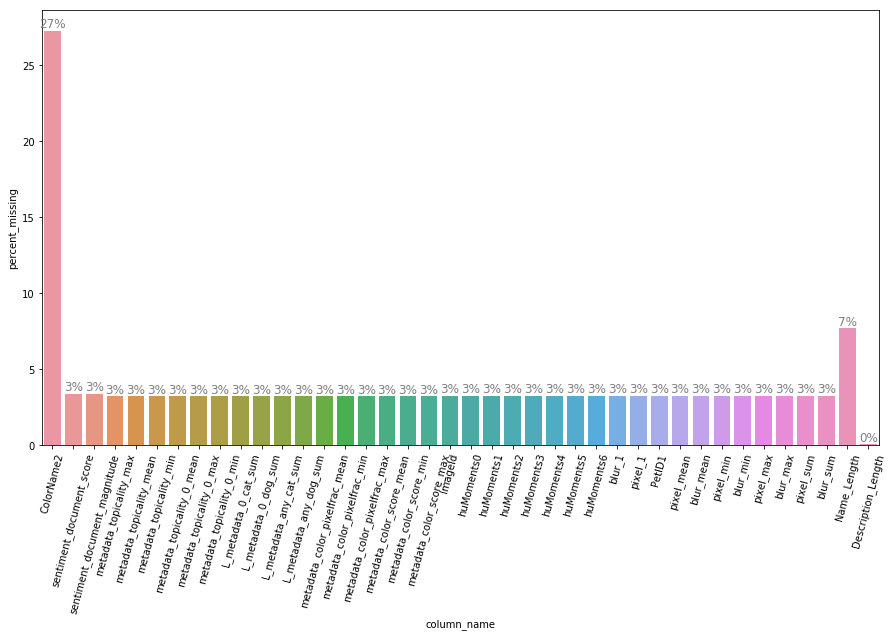

In [65]:
columns = df.columns
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

missing_value_df =missing_value_df[missing_value_df['percent_missing']>0]
missing_value_df


plt.figure(figsize=(15, 8))
ax = sns.barplot(x="column_name", y="percent_missing", data=missing_value_df, label='Sales')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % round(p.get_height(),2) + '%', 
            fontsize=12, color='grey', ha='center', va='bottom') 
    
plt.show()

In [66]:
for col in ['sentiment_document_score', 'sentiment_document_magnitude','metadata_topicality_max','metadata_topicality_mean','metadata_topicality_min',
           'metadata_topicality_0_mean','metadata_topicality_0_max','metadata_topicality_0_min','L_metadata_0_dog_sum',
           'L_metadata_0_cat_sum','L_metadata_any_dog_sum','L_metadata_any_cat_sum','pixel_mean','pixel_min','pixel_max','pixel_sum',
           'blur_min','blur_max','blur_sum','blur_mean','metadata_color_pixelfrac_mean','metadata_color_pixelfrac_min',
           'metadata_color_pixelfrac_max','metadata_color_score_mean','metadata_color_score_min','metadata_color_score_max',
            'Name_Length','Description_Length','huMoments0','huMoments1','huMoments2','huMoments3','huMoments4','huMoments5','huMoments6']:
    

    df[col].fillna((df[col].median()), inplace=True)
    
# replacing na values with No Color 
df["ColorName2"].fillna("No Color", inplace = True) 

### Feature Categorization

In [67]:
#One Hot Encoding
df = pd.concat([df.drop('StateName', axis=1),pd.get_dummies(df['StateName'], prefix='State')], axis=1)

col=['ColorName1','ColorName2','Health', 'Gender', 'Dewormed','Type','MaturitySize', 'Sterilized','Vaccinated','FurLength']
for i in col:
    df = pd.concat([df.drop(i, axis=1),pd.get_dummies(df[i], prefix=i)], axis=1)

In [68]:
output= name.value + "_features.csv"
print(output)
filepath= os.path.join(r"C:\Users\alexandra\Documents\Kaggle", output)
df.to_csv(filepath)

test_features.csv
